In [1]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
# from tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils
from torchvision.datasets import ImageFolder

import cv2
import PIL
import matplotlib.pyplot as plt

from my_utils import data, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")

Using cuda now!


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


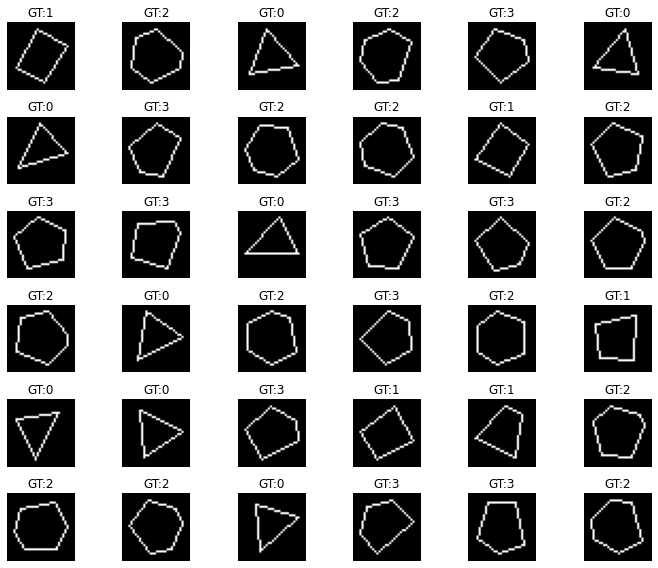

In [7]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(f"GT:{labels[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

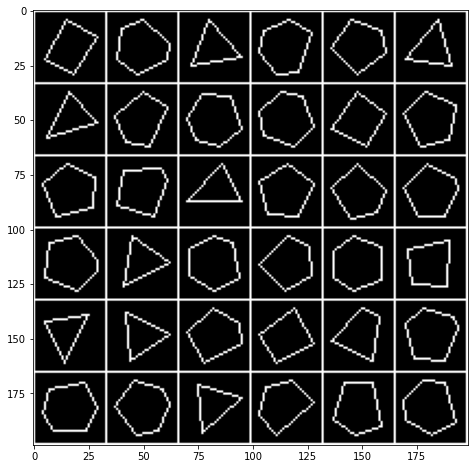

In [8]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))

In [9]:
def check_accuracy(test_model, loader):
    num_correct = 0
    num_samples = 0
    test_model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(loader):
            X = X.to(device, dtype=torch.float32)  # move to device, e.g. GPU
            Y = Y.to(device, dtype=torch.int)
            scores = test_model(X)
            num_correct += (scores.argmax(axis=1) == Y).sum()
            num_samples += len(scores)
        return float(num_correct) / num_samples

def train(model, optimizer, loss_fn, train_loader,
          check_fn, check_loaders, batch_step, epochs=2, log_every=10):
    check_loader_train = check_loaders['train']
    check_loader_val = check_loaders['val']
    iters = len(train_loader)
    for epoch in range(1, epochs + 1):
        tic = time.time()
        for batch_idx, (X, Y) in enumerate(train_loader):
            batch_step += 1
            model.train()
            X = X.to(device, dtype=torch.float32)
            Y = Y.to(device, dtype=torch.int64)
            scores = model(X)
            loss = loss_fn(scores, Y)
            writer.add_scalar('loss', loss.item(), batch_step)
            writer.add_scalar('lr', optimizer.param_groups[0]['lr'], batch_step)

            # back propagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(batch_step / iters)

            # check accuracy
            if batch_idx % log_every == 0:
                model.eval()
                train_acc = check_fn(model, check_loader_train)
                val_acc = check_fn(model, check_loader_val)
                writer.add_scalars('acc', {'train':train_acc, 'val':val_acc}, batch_step)
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tVal acc: {:.1f}%'.format(
                    epoch, batch_idx * batch_size, len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                           loss, 100. * val_acc))

        print('====> Epoch: {}\tTime: {}s'.format(epoch, time.time() - tic))

    return batch_step

In [12]:
model = models.my_ConvNeXt(in_chans=1, num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
loss_func = nn.CrossEntropyLoss()

In [12]:
# copy the following line to prompt line!
# tensorboard --logdir runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [13]:
writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

In [14]:
# reset train history
batch_step = 0

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1)

In [15]:
# Train and test!

check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [ ]:
batch_step = train(model, optimizer, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=60, log_every=50)

Epoch: 1 [0/40000 (0%)]	Loss: 1.59883	Val acc: 24.7%
Epoch: 1 [6400/40000 (16%)]	Loss: 1.54009	Val acc: 24.9%
Epoch: 1 [12800/40000 (32%)]	Loss: 1.45237	Val acc: 24.6%
Epoch: 1 [19200/40000 (48%)]	Loss: 1.44881	Val acc: 16.8%
Epoch: 1 [25600/40000 (64%)]	Loss: 1.49201	Val acc: 14.3%
Epoch: 1 [32000/40000 (80%)]	Loss: 1.42473	Val acc: 11.5%
Epoch: 1 [38400/40000 (96%)]	Loss: 1.46913	Val acc: 11.2%
====> Epoch: 1	Time: 12.327987432479858s
Epoch: 2 [0/40000 (0%)]	Loss: 1.45580	Val acc: 11.7%
Epoch: 2 [6400/40000 (16%)]	Loss: 1.40324	Val acc: 24.9%
Epoch: 2 [12800/40000 (32%)]	Loss: 1.38086	Val acc: 30.3%
Epoch: 2 [19200/40000 (48%)]	Loss: 1.34676	Val acc: 28.4%
Epoch: 2 [25600/40000 (64%)]	Loss: 1.34431	Val acc: 48.4%
Epoch: 2 [32000/40000 (80%)]	Loss: 1.29737	Val acc: 44.9%
Epoch: 2 [38400/40000 (96%)]	Loss: 1.29742	Val acc: 40.1%
====> Epoch: 2	Time: 12.179827213287354s
Epoch: 3 [0/40000 (0%)]	Loss: 1.28196	Val acc: 40.6%
Epoch: 3 [6400/40000 (16%)]	Loss: 1.29113	Val acc: 45.6%
Epoch: 3

In [25]:
writer.close()

In [21]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 88.67%


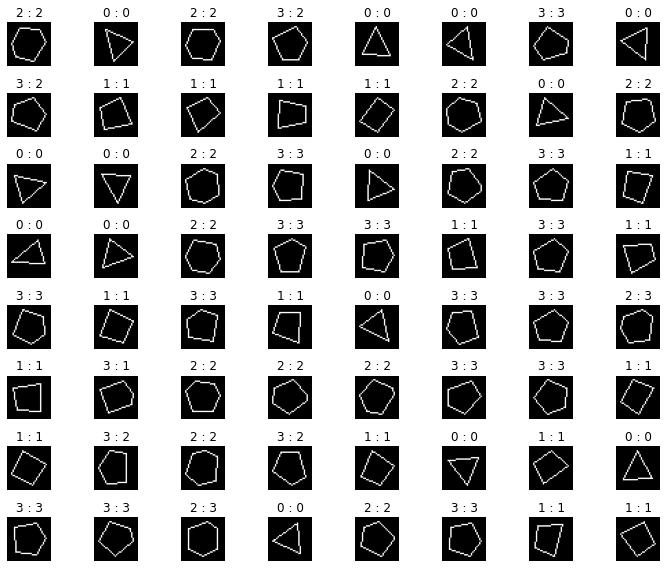

In [22]:
imgs, labels = next(iter(test_loader))
scores = model(imgs.to(device))
preds = scores.argmax(axis=1)

vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

In [23]:
# Save weights of the model above
model_paras = model.state_dict()
print("Model parameters:")
for k, v in model_paras.items():
    print(f"{k}:\t {v.size()}")

optim_paras = optimizer.state_dict()
print("\nOptimizer parameters:")
for k, v in optim_paras.items():
    print(f"{k}")

save_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
save_path = "saved_models/polygen_myconvnext_" + save_time + ".pt"
torch.save({
    "model_paras": model_paras,
    "optim_paras": optim_paras
}, save_path)
print(f"\nSuccessfully saved to {save_path}")

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv

In [27]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters())

save_path = 'saved_models/polygen_myconvnext_2022_01_19_18_37_31.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

RuntimeError: Error(s) in loading state_dict for my_ConvNeXt:
	size mismatch for head.weight: copying a param with shape torch.Size([4, 32]) from checkpoint, the shape in current model is torch.Size([5, 32]).
	size mismatch for head.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([5]).

In [19]:
new_model.eval()
test_acc = check_accuracy(test_loader, new_model)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 41.60%


In [24]:
imgs, labels = next(iter(test_loader))
scores = new_model(imgs.to(device))
preds = scores.argmax(axis=1)

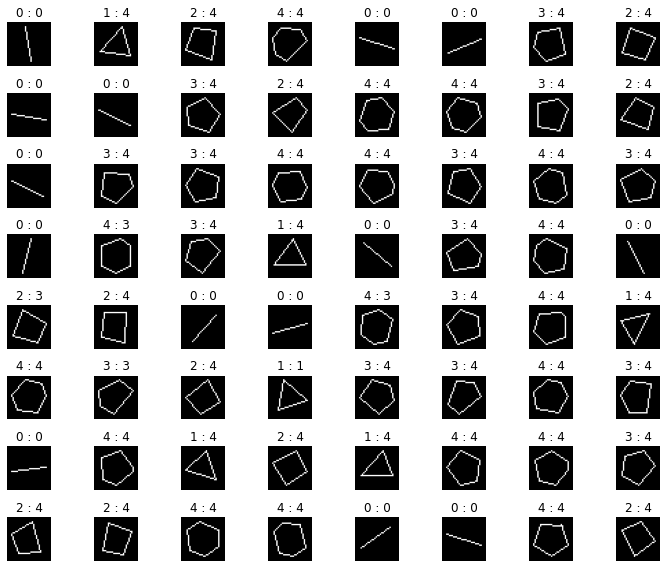

In [26]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()